# Overview

## Simulated earthquake experiment

The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. 

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.   

## Competition 

In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.  
Objective of the competition is to predict the failures for each test set.  

# Initialization

## Load packages

In [132]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

## Load the data

Let's see first what files we have in input directory.

In [4]:
IS_LOCAL = True
if(IS_LOCAL):
    PATH="../dsc-5-capstone-project-online-ds-sp-000/LANL-Earthquake-Prediction"
else:
    PATH="../input/"
os.listdir(PATH)

['sample_submission.csv', 'test', 'train.csv']

We have two files in the **input** directory and another directory, with the **test** data.  

Let's see how many files are in **test** folder.

In [5]:
print("There are {} files in test folder".format(len(os.listdir(os.path.join(PATH, 'test' )))))

There are 2624 files in test folder




Let's load the train file.

In [6]:
%%time
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 2min 35s


Let's check the data imported.

In [7]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [8]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


# <a id='3'>Data exploration</a>  

The dimmension of the data is quite large, in excess of 600 millions rows of data.  
The two columns in the train dataset have the following meaning:   
*  accoustic_data: is the accoustic signal measured in the laboratory experiment;  
* time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data.  

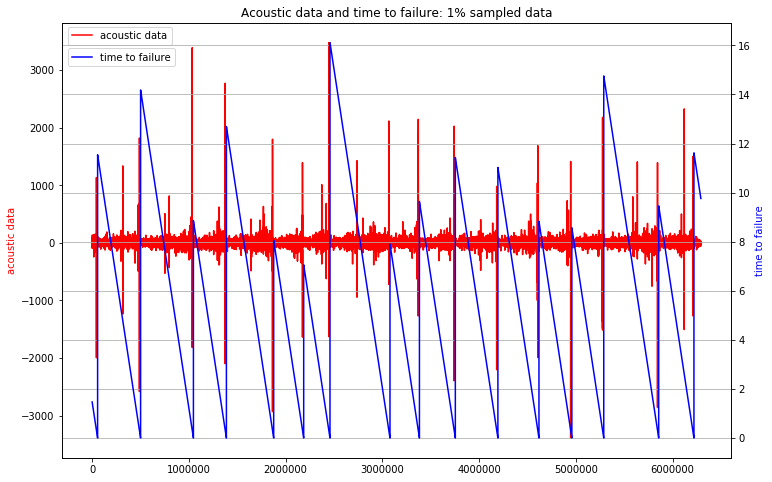

In [9]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data. 
The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data.

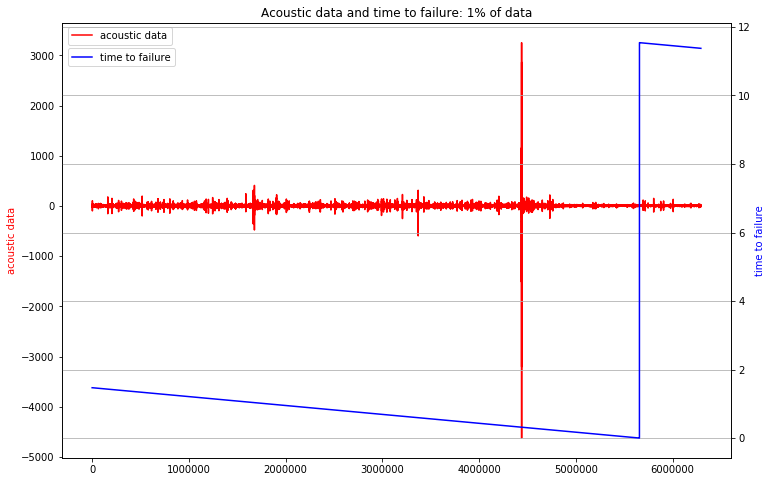

In [10]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

# Scrubbing the Data

The test segments are 150,000 rows each. We split the train data in segments of the same dimmension with the test sets. We will create additional aggregation features, calculated on the segments. 


In [95]:
SEGMENT_ROWS = 150000
TRAIN_SEGMENTS = 20000

Let's define some computation helper functions.

In [12]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

## Process train file

Now let's calculate the aggregated functions for train set.

In [13]:
train_X = pd.DataFrame(index=range(TRAIN_SEGMENTS), dtype=np.float64)
train_y = pd.DataFrame(index=range(TRAIN_SEGMENTS), dtype=np.float64, columns=['time_to_failure'])

In [14]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    # X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    # X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.05)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [ ]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        
        x = pd.Series(x)
    
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
        
        main_dict = self.features(x, y, seg_id)
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v
                
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
        
        return main_dict
        
    
    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]

        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()

        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()

        # geometric and harminic means
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)

        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)

        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)

        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)

        feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        feature_dict['med'] = x.median()

        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()

        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        for autocorr_lag in autocorr_lags:
            feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
            feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

        for p in percentiles:
            feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

        for peak in peaks:
            feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x.rolling(w).std().dropna().values
            x_roll_mean = x.rolling(w).mean().dropna().values

            feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()       

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)

In [ ]:
training_fg = FeatureGenerator(dtype='train', n_jobs=20, chunk_size=150000)
training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=20, chunk_size=150000)
test_data = test_fg.generate()

In [108]:
# Create indices for splitting train data into segments
total_rows = train_df.shape[0]
scaling_factor = ((total_rows - SEGMENT_ROWS) / (TRAIN_SEGMENTS - 1))
seg_inds = np.round(np.array(range(0, TRAIN_SEGMENTS)) * scaling_factor).astype(int)
# print(seg_inds, n_rows)

[        0     31451     62903 ... 628932577 628964029 628995480] 629145480


In [109]:
# Iterate over all segments
for seg_id in tqdm_notebook(range(TRAIN_SEGMENTS)):
    seg_ind = seg_inds[seg_id]
    seg = train_df.iloc[seg_ind:seg_ind+SEGMENT_ROWS]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Let's check the result. We plot the shape and the head of train_X.

In [123]:
train_X.shape

(20000, 152)

In [124]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,1.200000000000000e+01,2349.811481800189085,732617.0,-20121.154171234855312,-8.246085296074549e-16,1399.854635310395224,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,-0.000001704697987,74222.343442640820285,5.629
1,4.804520000000000,5.315805610459741,181.0,-154.0,5.820766091346741e-16,2359.256980491951253,720678.0,-16440.622278823393572,-9.701276818911235e-16,1461.183937771011642,...,0.303317105706001,5.667,3.412,4.069,4.359,5.320,5.483,-0.000003194630872,74376.616954416866065,5.667
2,4.784506666666666,6.283940314483798,181.0,-154.0,7.000000000000002e+00,2529.560633786033122,717676.0,-28310.900588266653358,-1.940255363782247e-15,1719.926161205765084,...,0.307909597584823,5.667,3.412,4.069,4.357,5.316,5.483,-0.000004610738255,74719.640580404797220,5.667
3,4.674913333333333,6.098348404131833,181.0,-154.0,-1.700000000000000e+01,2462.439034778323276,701237.0,-22809.793150635196071,1.164153218269348e-15,1671.157682566190260,...,0.244232210358985,5.667,3.412,4.068,4.303,5.063,5.180,-0.000003208053691,74520.751679706809227,5.667
4,4.674860000000000,6.572926694872606,181.0,-154.0,6.000000000000000e+00,2558.442592672347018,701229.0,-26220.097707311902923,1.406685138742129e-15,1792.468828180841683,...,0.245599081626349,5.667,3.412,4.067,4.291,5.038,5.154,-0.000000261744966,74513.184175338639761,5.667
5,4.725486666666667,6.833176936477097,181.0,-154.0,9.999999999999981e-01,2625.448723551842704,708823.0,-27262.120701140142046,-4.365574568510056e-16,1860.201870765643662,...,0.227011526272443,5.667,3.412,4.233,4.348,5.062,5.231,-0.000003348993289,74375.581324667597073,5.667
6,4.734380000000000,6.189464280430135,152.0,-150.0,4.999999999999999e+00,2490.798064878001696,710157.0,-24377.582750012246834,1.697723443309466e-15,1704.240299957725938,...,0.237285395930347,5.476,3.905,4.193,4.313,5.065,5.229,0.000002201342282,74449.843638685153564,5.476
7,4.743066666666667,5.565597161853704,111.0,-115.0,8.999999999999998e+00,2385.523527446333901,711460.0,-22320.880670903505234,1.164153218269348e-15,1526.449638867918793,...,0.225392043727188,5.476,3.905,4.193,4.319,5.058,5.221,0.000000825503356,74651.671478227988700,5.476
8,4.808913333333333,5.823639067138529,111.0,-115.0,6.000000000000002e+00,2452.491997948209246,721337.0,-23819.996875892589742,5.820766091346741e-16,1594.138011591217037,...,0.243049523954471,5.510,3.905,4.234,4.366,5.216,5.390,0.000000093959732,74491.746047058142722,5.510
9,4.864460000000000,6.294063314739804,140.0,-106.0,9.000000000000002e+00,2554.709278959153835,729669.0,-31950.435339638246660,-1.358178754647573e-15,1721.938007014189679,...,0.249712054231851,5.604,4.055,4.239,4.445,5.288,5.418,0.000001926174497,74509.878612339598476,5.604


We scale the data.

In [129]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

Let's check the obtained dataframe.

In [130]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424199717512653,-0.169996035597264,-0.216543956753813,0.193398541057169,0.862488681842936,-0.105062871579779,1.424199717512650,0.154071783374605,-0.344062044060247,-0.168825594986075,...,0.270969410574731,-0.005210721560007,0.178693395780247,0.287590628365541,0.962735241951625,1.510454215317761,0.892638693712182,-0.627094615841200,-1.830171554025171,-0.005210721560007
1,1.113411642656851,-0.144812341517014,0.062884925640967,-0.017543195532482,-0.510108635538250,-0.100861491126760,1.113411642656848,0.281951780518955,-0.405066527202697,-0.142558154905010,...,0.319732412262967,0.006873290870208,-0.024763092771720,0.281286304888722,0.890659910981041,1.445179381485123,0.890360216453883,-1.171419060477980,-0.811508684011232,0.006873290870208
2,1.035265583462853,-0.031252642949922,0.062884925640967,-0.017543195532482,0.290573132934108,-0.025110018030735,1.035265583462853,-0.130480770179492,-0.811763081485692,-0.031738439404766,...,0.349189171415219,0.006873290870208,-0.024763092771720,0.281286304888722,0.883452377883983,1.430673862855647,0.890360216453883,-1.688772474074198,1.453464915855377,0.006873290870208
3,0.607336513812589,-0.053022094358345,0.062884925640967,-0.017543195532482,-2.454621501828264,-0.054965866117650,0.607336513812587,0.060655083001271,0.489665892219894,-0.052626058195675,...,-0.059244748219166,0.006873290870208,-0.024763092771720,0.279184863729781,0.688848984263401,0.513199809541342,0.199981607189308,-1.176322884303536,0.140208115860837,0.006873290870208
4,0.607128263155175,0.002644712563255,0.062884925640967,-0.017543195532482,0.176190023152343,-0.012263253506200,0.607128263155174,-0.057835871490484,0.591340030790643,-0.000668297048065,...,-0.050477482260454,0.006873290870208,-0.024763092771720,0.277083422570843,0.645603785681051,0.422540318107125,0.140741198473536,-0.099933554593869,0.090240136071066,0.006873290870208
5,0.804810199703879,0.033171393267683,0.062884925640967,-0.017543195532482,-0.395725525756485,0.017541234080580,0.804810199703877,-0.094040936782771,-0.181383422347049,0.028341875352755,...,-0.169700151725393,0.006873290870208,-0.024763092771720,0.625922654954842,0.851018478947218,0.509573429883976,0.316183947362554,-1.227813034471882,-0.818346912820035,0.006873290870208
6,0.839535996827392,-0.042334437564199,-0.042354523572652,-0.002475928633221,0.061806913370577,-0.042351701570542,0.839535996827391,0.006182268921152,0.713348997075541,-0.038456719312113,...,-0.103802396855072,-0.053864771607973,0.182476677592164,0.541865008597252,0.724886649748693,0.520452568856082,0.311626992845956,0.799918117395761,-0.327995321933734,-0.053864771607973
7,0.873454822653434,-0.115512438143031,-0.191141331081561,0.129362656735311,0.519339352497639,-0.089178068097047,0.873454822653433,0.077642336023268,0.489665892219894,-0.114604748880009,...,-0.180087694816504,-0.053864771607973,0.182476677592164,0.541865008597252,0.746509249039869,0.495067911254499,0.293399174779565,0.297276175276211,1.004667193559351,-0.053864771607973
8,1.130566290561194,-0.085244789581292,-0.191141331081561,0.129362656735311,0.176190023152343,-0.059390331936480,1.130566290561193,0.025555577473963,0.245647959650096,-0.085613708653589,...,-0.066830631763366,-0.043052760486203,0.182476677592164,0.628024096113783,0.915886276820745,1.068035897118769,0.678461831432083,0.030017776783380,-0.051315112335025,-0.043052760486203
9,1.347459350256190,-0.030065241183527,-0.085901881867942,0.163264007258647,0.519339352497639,-0.013923840392235,1.347459350256188,-0.256936322588037,-0.567745148915895,-0.030876762569960,...,-0.024096413629976,-0.013160729737779,0.245531374457443,0.638531301908481,1.200583834154560,1.329135232449322,0.742259194664454,0.699389728971851,0.068413613469419,-0.01316

## Feature Selection

First, drop features with correlations above 0.995

In [131]:
CORR_LIM = 0.995
largest_corr = 1

while True:
    largest_corr = 0
    largest_col = None
    
    # Calculate correlation matrix
    corr_mat = scaled_train_X.corr().values
    
    # Loop across columns
    for i, col in enumerate(scaled_train_X.columns):
        
        #Get correlations for that columns
        col_corr = corr_mat[i]
        
        #Remove correlation with itself
        col_corr = np.delete(col_corr, i)
        
        #Get maximum correlation with other variables
        max_corr = col_corr.max()
        
        #If this column has a larger correlation, chose it for removal
        if max_corr > largest_corr:
            largest_corr = np.round(max_corr, decimals = 5)
            largest_col = col
            
    #End loop if largest corr is under CORR_LIM
    if largest_corr < CORR_LIM:
        break
        
    #Remove column with highest correlation among columns        
    print(f'Dropping {largest_col}, Max Correlation: {largest_corr}')
    scaled_train_X.drop(largest_col, axis = 1, inplace = True)      

Dropping ave_roll_std_1000, Max Correlation: 1.0
Dropping mean, Max Correlation: 1.0
Dropping Rmax, Max Correlation: 1.0
Dropping Rmin, Max Correlation: 1.0
Dropping sum, Max Correlation: 1.0
Dropping Hann_window_mean, Max Correlation: 1.0
Dropping Moving_average_700_mean, Max Correlation: 1.0
Dropping Moving_average_1500_mean, Max Correlation: 1.0
Dropping max_roll_std_10, Max Correlation: 1.0
Dropping ave_roll_mean_10, Max Correlation: 1.0
Dropping max_roll_std_100, Max Correlation: 1.0
Dropping max_roll_std_1000, Max Correlation: 1.0
Dropping max_roll_mean_1000, Max Correlation: 1.0
Dropping Istd, Max Correlation: 0.99999
Dropping exp_Moving_average_300_mean, Max Correlation: 0.99999
Dropping ave_roll_mean_100, Max Correlation: 0.99999
Dropping av_change_rate_roll_std_1000, Max Correlation: 0.99997
Dropping ave_roll_mean_1000, Max Correlation: 0.99996
Dropping mad, Max Correlation: 0.99996
Dropping exp_Moving_average_3000_mean, Max Correlation: 0.99994
Dropping Moving_average_6000_m

In [134]:
scaled_train_X.to_pickle("../scaled_train_X_051419_v1.pkl")

In [136]:
pd.read_pickle("../scaled_train_X_051419_v1.pkl").head()

,min,Rmean,Rstd,Imean,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,...,abs_max_roll_std_1000,std_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,0.193398541057169,0.862488681842936,-0.105062871579779,-0.344062044060247,-0.085396321815606,0.085396321815606,-0.037196582553997,-0.191625344651606,-0.205889567866725,0.051858778121690,...,-0.111752343476650,0.270969410574731,0.178693395780247,0.287590628365541,0.962735241951625,1.510454215317761,0.892638693712182,-0.627094615841200,-1.830171554025171,-0.005210721560007
1,-0.017543195532482,-0.510108635538250,-0.100861491126760,-0.405066527202697,-0.174433094583157,0.174433094583157,1.160592420988601,-0.006875175201480,-0.087517122668555,0.143505253205225,...,-0.023051711088892,0.319732412262967,-0.024763092771720,0.281286304888722,0.890659910981041,1.445179381485123,0.890360216453883,-1.171419060477980,-0.811508684011232,0.006873290870208
2,-0.017543195532482,0.290573132934108,-0.025110018030735,-0.811763081485692,-0.013441290655611,0.013441290655611,-0.115872928078548,0.007396189754065,0.105698046968379,0.083045139472567,...,-0.023051711088892,0.349189171415219,-0.024763092771720,0.281286304888722,0.883452377883983,1.430673862855647,0.890360216453883,-1.688772474074198,1.453464915855377,0.006873290870208
3,-0.017543195532482,-2.454621501828264,-0.054965866117650,0.489665892219894,-0.056286831897878,0.056286831897878,-0.680887724306356,-0.003799174862428,-0.022715118806411,0.037842943407424,...,-0.023051711088892,-0.059244748219166,-0.024763092771720,0.279184863729781,0.688848984263401,0.513199809541342,0.199981607189308,-1.176322884303536,0.140208115860837,0.006873290870208
4,-0.017543195532482,0.176190023152343,-0.012263253506200,0.591340030790643,-0.007500671890334,0.007500671890334,0.220957080299519,0.011272871356482,-0.017553698662696,0.029187109086417,...,-0.023051711088892,-0.050477482260454,-0.024763092771720,0.277083422570843,0.645603785681051,0.422540318107125,0.140741198473536,-0.099933554593869,0.090240136071066,0.006873290870208


## Process test data

We apply the same processing done for the training data to the test data.

We read the submission file and prepare the test file.

In [22]:
submission = pd.read_csv(PATH + '/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

Let's check the shape of the submission and test_X datasets.

In [23]:
submission.shape, test_X.shape

((2624, 1), (2624, 154))

In [25]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv(PATH + '/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

We scale also the test data.

In [26]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [27]:
scaled_test_X.shape

(2624, 154)

In [28]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081634623438432,-0.268601942297170,-0.350098217792172,0.329025264342352,-0.081175674433600,-0.256057804503499,-1.081634623438434,0.296094951842351,-0.903787583787889,-0.265116961140863,...,-0.131863367972886,-0.197756385756125,0.067608697543058,-0.245432983826332,-0.755380587355362,-0.834320554361995,-0.568229086274198,-0.621183095678739,-0.332742633283314,-0.197756385756125
2615,-0.734695164615844,-0.320940103313106,-0.390402434461477,0.400701222773672,0.559070265527884,-0.271490841421192,-0.734695164615847,0.457524666141680,-0.286162051454442,-0.320648190853422,...,-0.090273729721340,-0.210475627620636,-0.012763104918716,-0.420246542042718,-0.632725192900742,-0.772650186338005,-0.620301201202069,0.066789756975814,0.379958267345616,-0.210475627620636
2616,-2.073321685925087,0.185999424044793,0.045615909506462,0.027231755157847,0.238947295547142,0.058192651768876,-2.073321685925090,-0.198272835507732,0.285713441446897,0.182882262889467,...,-0.335397473385972,-0.255310955193040,-0.100709213371653,-0.919713851232396,-1.650043464553771,-2.114887608036642,-1.421758970091934,-0.681886582677671,-0.455029743769391,-0.255310955193040
2617,-0.427930383839279,-0.291596382505905,-0.196209390509370,0.310163170018320,0.238947295547142,-0.242327244436703,-0.427930383839283,0.412107554533329,0.148463323150576,-0.293675558394082,...,-0.306297807314964,-0.147833361437917,0.084019693857243,-0.076862766974816,-0.026663243830852,-0.547734726485800,-0.409748736493715,0.491714165968333,0.259853681784336,-0.147833361437917
2618,-3.374741716678421,-0.152003490043613,-0.298801942031238,0.234714792722194,-0.721421614395085,-0.249113638779983,-3.374741716678424,0.271951919845560,0.400088540027165,-0.156716904848106,...,-0.176297932752017,-0.424476871991044,-0.208011881579782,-1.854133942174751,-3.157983314025280,-3.239464907297666,-2.157560594072741,-0.466895066223123,-0.517982573703920,-0.424476871991044
2619,-1.654729139621841,-0.172408272635866,-0.339106158700543,0.374294290720027,-1.041544584375827,-0.215590231150948,-1.654729139621846,0.224509483145720,0.468713599175326,-0.166937482945480,...,-0.035382823436088,-0.240683827048852,-0.014025489250577,-0.663736855272686,-1.487705442481479,-1.469162578138378,-0.817269635929239,0.643472883465663,-0.554972820552376,-0.240683827048852
2620,-1.487885758598570,-0.060792925011133,0.001647673139947,-0.221747889919369,0.238947295547142,-0.124402235161050,-1.487885758598571,0.230258375488919,0.468713599175326,-0.063658336471214,...,0.301725399442915,-0.128754498641149,-0.147417433650486,-1.354666632985074,-2.028832182722451,-1.425630553650856,-0.894245805822615,1.559083812366209,-0.820948539836463,-0.128754498641149
2621,-3.010670087956753,0.343254632011415,0.536594548932544,-0.580127682075968,-0.241237159423972,0.174257853534564,-3.010670087956756,-0.487617919728305,0.171338342866629,0.340983182941972,...,-0.166314501054057,-0.130344403874213,-0.335933493874962,-1.564859125602396,-2.624071596987521,-2.956506748128763,-1.935688104380066,1.604611427615407,-0.954385032173800,-0.130344403874213
2622,-0.694312192710866,0.782096807867229,0.727123573187442,-0.640486383912869,-0.241237159423972,0.628381731544477,-0.694312192710869,-1.113687307556833,1.109214151224826,0.778366527088963,...,-0.045220121607113,0.055356527347656,-0.178977041946994,-0.303704169898461,-0.679622843721626,-0.761767180216124,0.006828182929265,0.916638574960853,1.362109444329824,0.055356527347656
2623,-1.248764408517769,-0.349888468230792,-0.331778119306124,0.347887358666383,0.238947295547142,-0.306138783032271,-1.248764408517773,0.388179518203963,0.108432038647482,-0.350400284361961,...,-0.256027867555159,-0.247997391120946,0.047831343010580,-0.497247752209461,-0.97183128

In [138]:
scaled_test_X.to_pickle("../scaled_test_X_051419_v1.pkl")


# Model the Data

Let's prepare the model.



## XGBoost

## Run model

We define the folds for cross-validation.

In [29]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

We define the model parameters.

In [30]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

In [31]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95699	valid_1's l1: 2.25577
[2000]	training's l1: 1.56523	valid_1's l1: 2.12802
[3000]	training's l1: 1.33508	valid_1's l1: 2.10585
[4000]	training's l1: 1.16012	valid_1's l1: 2.10369
Early stopping, best iteration is:
[3774]	training's l1: 1.19668	valid_1's l1: 2.1031
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.94885	valid_1's l1: 2.27538
[2000]	training's l1: 1.55804	valid_1's l1: 2.14451
[3000]	training's l1: 1.33287	valid_1's l1: 2.12267
[4000]	training's l1: 1.15897	valid_1's l1: 2.11827
Early stopping, best iteration is:
[3803]	training's l1: 1.19053	valid_1's l1: 2.11804
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95801	valid_1's l1: 2.28033
[2000]	training's l1: 1.57234	valid_1's l1: 2.11711
[3000]	training's l1: 1.3439	valid_1's l1: 2.08428
[4000]	training's l1: 1.16803	valid_1's l1: 2.

## Features importance

Let's print features importance.

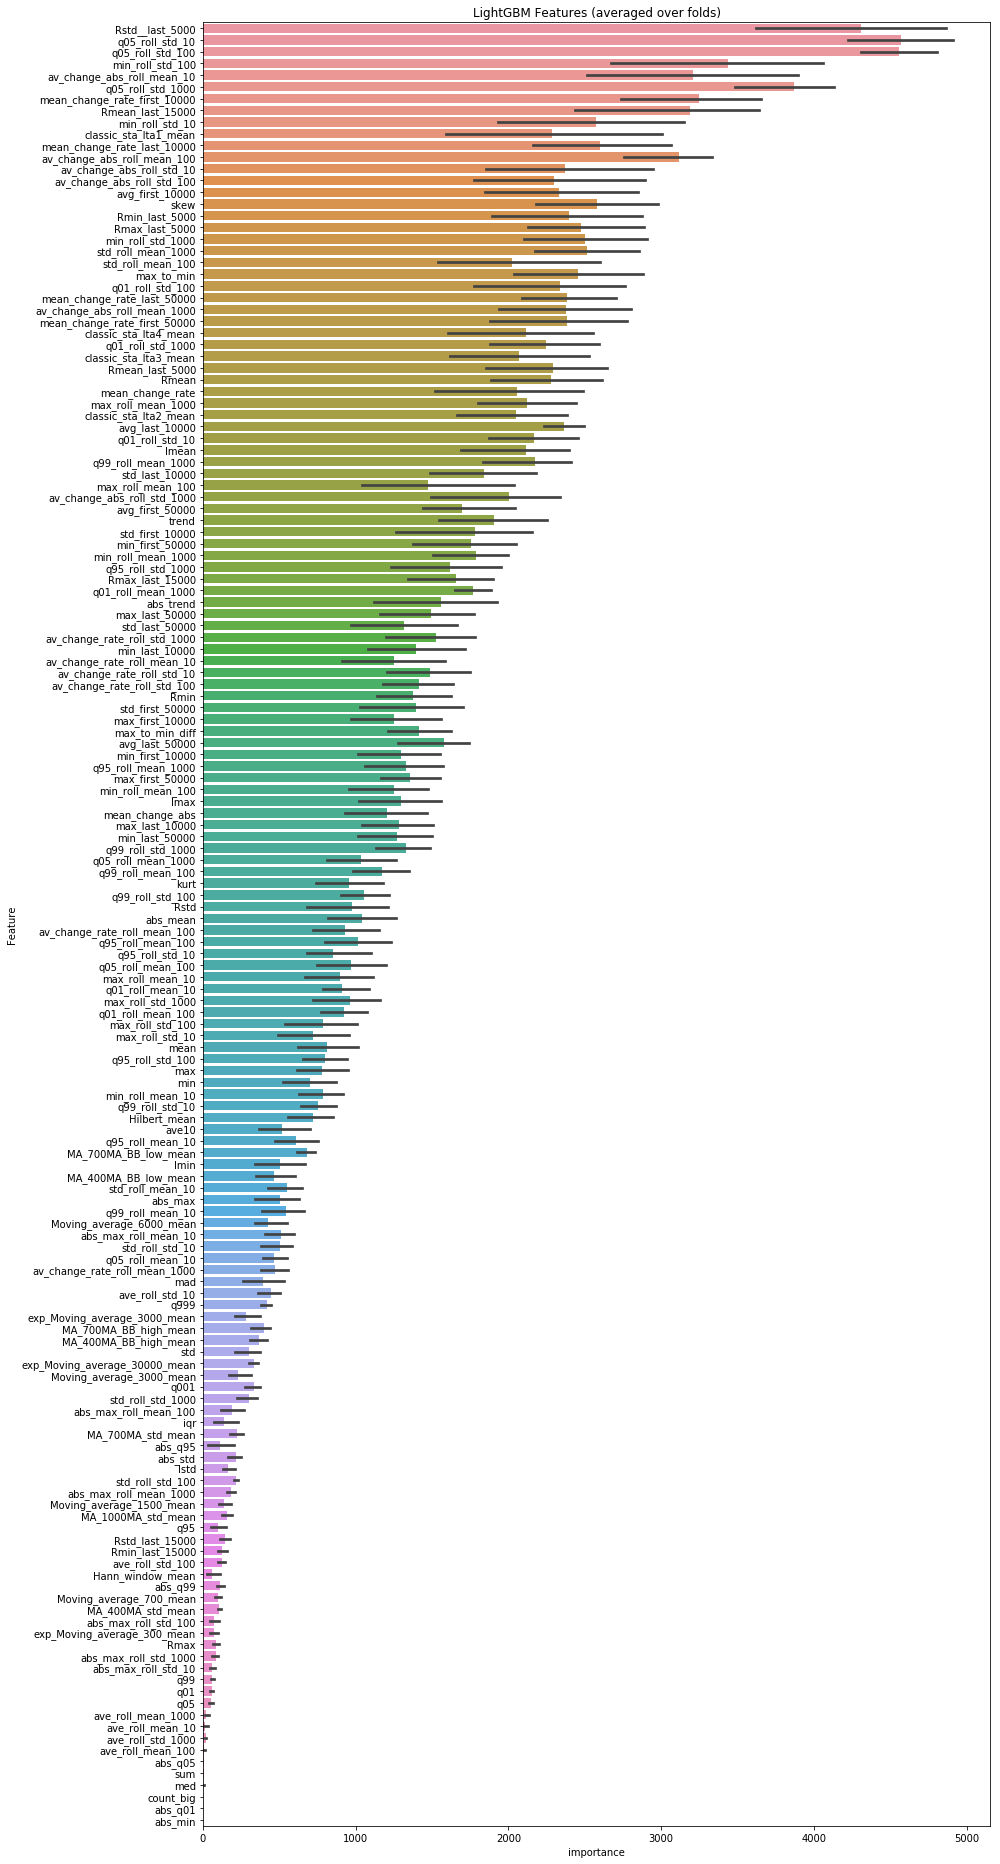

In [32]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [ ]:
submission.time_to_failure = predictions
submission.to_csv('submission.csv',index=True)

# <a id='7'>References</a>  

[1] Fast Fourier Transform, https://en.wikipedia.org/wiki/Fast_Fourier_transform   
[2] Shifting aperture, in Neural network for inverse mapping in eddy current testing, https://www.researchgate.net/publication/3839126_Neural_network_for_inverse_mapping_in_eddy_current_testing   
[3] Andrews Script plus a Genetic Program Model, https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model/